In [1]:
!pip install transformers

     |████████████████████████████████| 4.0 MB 5.1 MB/s 
     |████████████████████████████████| 6.6 MB 33.9 MB/s 
     |████████████████████████████████| 77 kB 6.6 MB/s 
     |████████████████████████████████| 895 kB 49.8 MB/s 
     |████████████████████████████████| 596 kB 58.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
!pip install nlpaug

     |████████████████████████████████| 410 kB 5.1 MB/s 


In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [3]:
import numpy as np 
import pandas as pd 
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn.functional as F
from transformers import BertTokenizer, BertConfig,AdamW, BertForSequenceClassification,get_linear_schedule_with_warmup
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import accuracy_score,matthews_corrcoef

from tqdm import tqdm, trange,tnrange,tqdm_notebook
import random
import os
import io
%matplotlib inline
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as nafc

from nlpaug.util import Action

In [4]:
import torch
torch.cuda.empty_cache()

In [5]:
import gc
gc.collect()

53

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
os.chdir('drive/MyDrive/William_2022')

In [8]:
!ls

'CMU SAIL LITERATURE LECTURES.gsheet'  'Meeting Notes.gdoc'
 DATASETS			       'RESEARCH NOTES.gdoc'


In [9]:
df = pd.read_csv('DATASETS/CSV/full_transcript_concat.csv')

In [10]:
df['arousal_trans'] = df['arousal_trans'].round()
df['arousal2_trans'] = df['arousal2_trans'].round()

df['valence_trans'] = df['valence_trans'].round()
df['valence2_trans'] = df['valence2_trans'].round()

df['happy_trans'] = df['happy_trans'].round()
df['happy2_trans'] = df['happy2_trans'].round()

df['angry_trans'] = df['angry_trans'].round()
df['angry2_trans'] = df['angry2_trans'].round()

df['nervous_trans'] = df['nervous_trans'].round()
df['nervous2_trans'] = df['nervous2_trans'].round()

df['sad_trans'] = df['sad_trans'].round()
df['sad2_trans'] = df['sad2_trans'].round()

In [11]:
df1 = df[['new_words', 'nervous_trans']]

In [12]:
df1['nervous_trans'] = df1['nervous_trans'].astype(int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [13]:
df1['nervous_trans'].value_counts()

1    907
2    890
3     66
Name: nervous_trans, dtype: int64

In [14]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
df1['label_enc'] = labelencoder.fit_transform(df1['nervous_trans'])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [15]:
df1['label_enc'].value_counts()

0    907
1    890
2     66
Name: label_enc, dtype: int64

In [ ]:
'''
0 - very low
1 - low
2 - high
'''

In [16]:
def to_emotion(rating):
  rating = int(rating)
  if rating == 2:
    return 'low'
  elif rating == 3:
    return 'high'
  else: 
    return 'very low'

df1['nervous_trans'] = df1.nervous_trans.apply(to_emotion)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [17]:
df1['nervous_trans'].value_counts()

very low    907
low         890
high         66
Name: nervous_trans, dtype: int64

In [18]:
df1.rename(columns={'nervous_trans':'label_desc'},inplace=True)
df1.rename(columns={'label_enc':'label'},inplace=True)


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [19]:
X_train = df1['new_words']

In [20]:
y_train = df1['label']

In [ ]:
X_train

482     for Koreans that we ourselves were officials o...
299     that these refugees can get into and therefore...
266       of Korea issue and I think me to take more care
16      for for Korea being under the UN Refugee Conve...
489     which stated that six people were killed which...
                              ...                        
1625                           they will refuse to employ
243     to sort out rather than just blocking all thos...
321     I'm really glad that you brought into other co...
1104                                    not logical thing
931     they call themselves Muslims so you're saying ...
Name: new_words, Length: 1490, dtype: object

In [21]:
aug = naw.SynonymAug(aug_src='wordnet',aug_max=3)


In [22]:



import nltk
nltk.download()

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> 

---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> l
Packages:
  [ ] abc................. Australian Broadcasting Commission 2006
  [ ] alpino.............. Alpino Dutch Treebank
  [ ] averaged_perceptron_tagger Averaged Perceptron Tagger
  [ ] averaged_perceptron_tagger_ru Averaged Perceptron Tagger (Russian)
  [ ] basque_grammars..... Grammars for Basque
  [ ] biocreative_ppi..... BioCreAtIvE (Critical Assessment of Information
         

True

In [23]:
y_train.value_counts()

0    907
1    890
2     66
Name: label, dtype: int64

In [24]:
augmented_sentences_0=[]
augmented_sentences_labels_0=[]
for i in X_train.index:
  if y_train[i]==2:
    temps=aug.augment(X_train[i],n=15)
    for sent in temps:
      augmented_sentences_0.append(sent)
      augmented_sentences_labels_0.append(2)

In [ ]:
len(augmented_sentences_labels_0)

1000

In [25]:
y_train.value_counts()

0    907
1    890
2     66
Name: label, dtype: int64

In [26]:
X_train=X_train.append(pd.Series(augmented_sentences_0),ignore_index=True)
y_train=y_train.append(pd.Series(augmented_sentences_labels_0),ignore_index=True)

In [27]:
X_y = pd.concat([X_train, y_train], axis = 1)

In [28]:
df = X_y

In [30]:
df

,0,1
0,all right first one the state for this accepti...,0
1,arrived in this especially in many Arab Jesus ...,0
2,Jeju Allah first of all I want to mention that...,0
3,movement in South Korea against against this y...,0
4,pretty much standard phobic activity because,0
...,...,...
2848,operating theater government agency jobs they ...,2
2849,or power jobs they can unbend labor engagement,2
2850,operating theatre role jobs they can relax pro...,2
2851,or office job they can relax labor exercise,2


In [32]:
df['label'].value_counts()

2    1056
0     907
1     890
Name: label, dtype: int64

In [31]:
df.rename(columns={0:'new_words'},inplace=True)
df.rename(columns={1:'label'},inplace=True)


In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

SEED = 19

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if device == torch.device("cuda"):
    torch.cuda.manual_seed_all(SEED)

In [34]:
device = torch.device("cuda")

In [35]:
sentences = df.new_words.values

In [ ]:
sentences.shape

(3313,)

In [ ]:
print("Distribution of data based on labels: ",df1.happy_trans.value_counts())

Distribution of data based on labels:  1    1231
2     608
3      24
Name: happy_trans, dtype: int64


In [36]:
MAX_LEN = 32

tokenizer = BertTokenizer.from_pretrained('bert-base-cased',do_lower_case=True)
input_ids = [tokenizer.encode(sent, add_special_tokens=True,max_length=MAX_LEN,pad_to_max_length=True) for sent in sentences]
labels = df.label.values

print("Actual sentence before tokenization: ",sentences[2])
print("Encoded Input from dataset: ",input_ids[2])

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Actual sentence before tokenization:  Jeju Allah first of all I want to mention that the current
Encoded Input from dataset:  [101, 179, 21024, 1358, 1155, 3354, 1148, 1104, 1155, 178, 1328, 1106, 4734, 1115, 1103, 1954, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [37]:
attention_masks = []

attention_masks = [[float(i>0) for i in seq] for seq in input_ids]
print(attention_masks[2])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [38]:
#stratified k fold

train_inputs,validation_inputs,train_labels,validation_labels = train_test_split(input_ids,labels,random_state=41,test_size=0.1)
train_masks,validation_masks,_,_ = train_test_split(attention_masks,input_ids,random_state=41,test_size=0.1)

In [39]:
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

batch_size = 20

train_data = TensorDataset(train_inputs,train_masks,train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data,sampler=train_sampler,batch_size=batch_size)

validation_data = TensorDataset(validation_inputs,validation_masks,validation_labels)
validation_sampler = RandomSampler(validation_data)
validation_dataloader = DataLoader(validation_data,sampler=validation_sampler,batch_size=batch_size)

In [40]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3).to(device)

lr = 2e-5
adam_epsilon = 1e-8

epochs = 30

num_warmup_steps = 0
num_training_steps = len(train_dataloader)*epochs

optimizer = AdamW(model.parameters(), lr=lr,eps=adam_epsilon,correct_bias=False)  
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps)  

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [41]:

val_accuracy_set = []
val_mcc_set = []
train_loss_set = []
learning_rate = []

model.zero_grad()

for _ in tnrange(1,epochs+1,desc='Epoch'):
  print("<" + "="*22 + F" Epoch {_} "+ "="*22 + ">")
  batch_loss = 0

  for step, batch in enumerate(train_dataloader):
    model.train()
    
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    loss = outputs[0]
    
    loss.backward()
    
    
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    
    optimizer.step()
    
    scheduler.step()

    optimizer.zero_grad()
    
    batch_loss += loss.item()

  avg_train_loss = batch_loss / len(train_dataloader)

  for param_group in optimizer.param_groups:
    print("\n\tCurrent Learning rate: ",param_group['lr'])
    learning_rate.append(param_group['lr'])
    
  train_loss_set.append(avg_train_loss)
  print(F'\n\tAverage Training loss: {avg_train_loss}')
  

  
    
  # Validation


  model.eval()

  eval_accuracy,eval_mcc_accuracy,nb_eval_steps = 0, 0, 0
  
  for batch in validation_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    logits = logits[0].to('cpu').numpy()
    label_ids = b_labels.to('cpu').numpy()

    pred_flat = np.argmax(logits, axis=1).flatten()
    labels_flat = label_ids.flatten()
    
    df_metrics=pd.DataFrame({'Epoch':epochs,'Actual_class':labels_flat,'Predicted_class':pred_flat})
    
    tmp_eval_accuracy = accuracy_score(labels_flat,pred_flat)
    tmp_eval_mcc_accuracy = matthews_corrcoef(labels_flat, pred_flat)
    
    eval_accuracy += tmp_eval_accuracy
    eval_mcc_accuracy += tmp_eval_mcc_accuracy
    nb_eval_steps += 1

  val_accuracy_set.append(eval_accuracy/nb_eval_steps)
  val_mcc_set.append(eval_mcc_accuracy/nb_eval_steps)

  print(F'\n\tValidation Accuracy: {eval_accuracy/nb_eval_steps}')
  print(F'\n\tValidation MCC Accuracy: {eval_mcc_accuracy/nb_eval_steps}')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  if __name__ == '__main__':


Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

<====================== Epoch 1 ======================>

	Current Learning rate:  1.9333333333333333e-05

	Average Training loss: 0.9332367683103843

	Validation Accuracy: 0.6444444444444443

	Validation MCC Accuracy: 0.46435930496029515
<====================== Epoch 2 ======================>

	Current Learning rate:  1.866666666666667e-05

	Average Training loss: 0.6248271721740102

	Validation Accuracy: 0.6777777777777777

	Validation MCC Accuracy: 0.5691733431846242
<====================== Epoch 3 ======================>

	Current Learning rate:  1.8e-05

	Average Training loss: 0.5217390088147895

	Validation Accuracy: 0.6222222222222221

	Validation MCC Accuracy: 0.5677548221371702
<====================== Epoch 4 ======================>

	Current Learning rate:  1.7333333333333336e-05

	Average Training loss: 0.4810209884199985

	Validation Accuracy: 0.6866666666666666

	Validation MCC Accuracy: 0.577445956973036
<====================== Epoch 5 ======================>

	Current Le

In [42]:
validation_accuracy= eval_accuracy/nb_eval_steps
print(validation_accuracy)

0.7255555555555555


In [43]:
mcc = eval_mcc_accuracy/nb_eval_steps
print(mcc)

0.5925193703786105


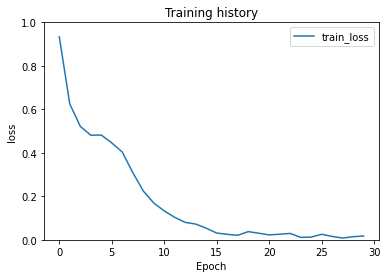

In [44]:
plt.plot(train_loss_set, label='train_loss')


plt.title('Training history')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

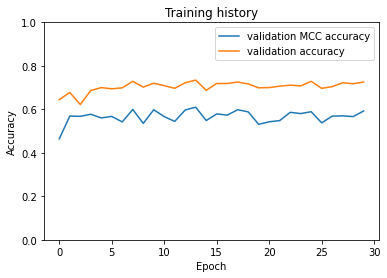

In [45]:
plt.plot(val_mcc_set, label='validation MCC accuracy')
plt.plot(val_accuracy_set, label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
len(input_ids)

3313

In [46]:
from sklearn.metrics import confusion_matrix,classification_report
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [47]:
cm = confusion_matrix(labels_flat, pred_flat)

Confusion matrix, without normalization
[[2 1 0]
 [0 2 0]
 [0 0 1]]


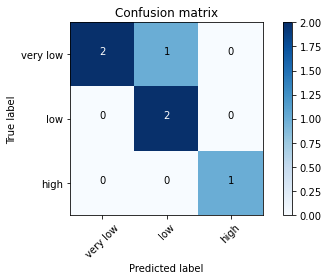

In [48]:
plot_confusion_matrix(cm, ['very low','low', 'high'])

In [ ]:
df[['label','label_desc']].drop_duplicates(keep='first')

,label,label_desc
0,1,low
1,2,very low
8,0,high


In [49]:
df_metrics

,Epoch,Actual_class,Predicted_class
0,30,0,0
1,30,2,2
2,30,1,1
3,30,0,0
4,30,1,1
5,30,0,1


In [50]:
label2int = {
  "high": 0,
  "low": 1,
  "verylow": 2
}

In [51]:
print(classification_report(df_metrics['Actual_class'].values, df_metrics['Predicted_class'].values, target_names=label2int.keys(), digits=len(label2int)))

              precision    recall  f1-score   support

        high      1.000     0.667     0.800         3
         low      0.667     1.000     0.800         2
     verylow      1.000     1.000     1.000         1

    accuracy                          0.833         6
   macro avg      0.889     0.889     0.867         6
weighted avg      0.889     0.833     0.833         6



In [ ]:
!ls

'CMU SAIL LITERATURE LECTURES.gsheet'  'Meeting Notes.gdoc'
 DATASETS			       'RESEARCH NOTES.gdoc'


In [52]:

model.save_pretrained('DATASETS')
#tokenizer.save_pretrained('DATASETS')

model_save_name = 'nervous_fineTuneModel_aug_30epoch.pt'
path = path_model = F'{model_save_name}'
torch.save(model.state_dict(),path)